# Model Discovery Assignment: 
BIOSCI 669: Mathematical Modeling and Methods

Assigned: Thursday 4/13/2023

Due: Thursday 4/20/2023 @MIDNIGHT


# Cancer and T-cell Dynamics
Problem description:
- You are a wet-lab researcher looking at the interactions between T-cells and cancer cell. You hypothesize that Tcells and cancer cells exhibit a predator-prey dynamic. You and your colleagues have painstakingly collected cell data every 3 hours for a week, and now it is your job to try to come up with a model for your data, and to argue whether or not your experiment has validated your hypothesis.
- I have generated the raw measurements, and created a Pareto plot for each population of cells. It is your job to pick the correct number of model terms for the underlying model to be "parsimonious".



Using the below codebase, and pretending you measured the data by hand, you will need to:


1. (***1 Paragraph with typeset equations***) 
  - Select a model from all candidate models, and justify your selection using the Pareto Front Analysis. I have given you the tools in the code below to pick your model
2. (***1 Paragraph with typeset equations***) 
  - Using your selected model, explain why the terms in the discovered model do or do not support your hypothesis of predator-prey behavior, given the data you "acquired".

Submit your report in a copy of this .ipynb, appending your name to the end of the filename, and use markdown to justify your research findings.

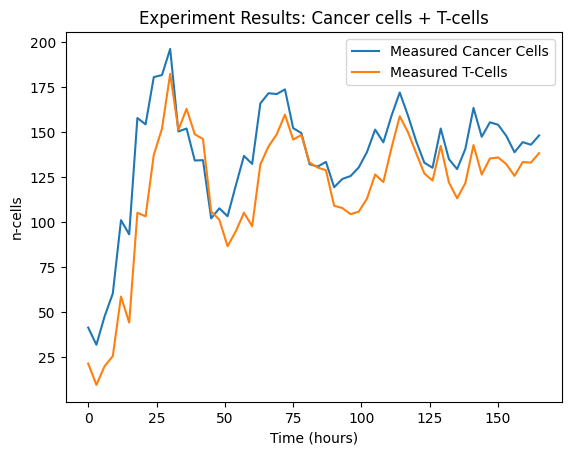

In [22]:
"""
This is the code-base which generates the model. 
Don't edit this area. 
You may use any function in this region in your analysis below.
"""
################################################################################
####################################DO NOT EDIT#################################
################################################################################
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
import warnings


def ExpGrowth(N,t,r):
    """
    Function which calculates the exponential growth of cells
    Inputs:
        - r, growth rate
        - N, number of cells
        - t, time

    Outputs:
        - dN/dt, growth rate of cells
    """
    dNdt = r*N
    return dNdt


def LogisticGrowth(N,t,r,K):
    """
    Function which calculates the logistic growth of cells
    
    Inputs:
        - r, growth rate
        - N, number of cells
        - K, carrying capacity
        - t, time

    Outputs:
        - dN/dt, growth rate of cells
    """
    dNdt = ExpGrowth(N,t,r) * (1-N/K)
    return dNdt


def AlleeGrowth(N,t,r,K,A):
    """
    Function which calculates the Allee growth of cells
    
    Inputs:
        - r, growth rate
        - N, number of cells
        - K, carrying capacity
        - A, Allee Threshold
        - t, time

    Outputs:
        - dN/dt, growth rate of cells
    """
    dNdt = LogisticGrowth(N,t,r,K) * (N/A-1)
    return dNdt


def PredatorPrey(N, t, r, K, A, r_eat, r_death, r_kill):
    """
    Function which calculates the predator-prey dynamics of cancer and Tcells
    
    Inputs:
        - t, time
        - r = [r_c, r_T], growth rate of cancer and Tcells
        - N = [N_c, N_T], number of cancer and Tcells
        - K = [K_c, K_T], carrying capacity of cancer and Tcells
        - r_eat, rate at which Tcells eat cancer
        - r_death, rate at which Tcells die out
        - r_kill, rate at which cancer is killed by Tcells

    Outputs:
        - dN/dt = [dN/dt_c, dN,dt_T], growth rate of of cancer and Tcells
    """

    #Unpack the variables
    r_c,r_T = r
    N_c,N_T = N
    K_c,K_T = K

    dNdt_c = LogisticGrowth(N_c, t, r_c, K_c) - r_kill * N_T
    dNdt_T = AlleeGrowth(N_T, t, r_T,  K_T, A) + r_eat * N_c - r_death * N_T

    return [dNdt_c, dNdt_T]


def AddNoise(signal, sigma = 5):
    """
    Add random noise to the curve to simulate data
    
    Inputs:
        - signal, np array of the smooth simulated data

    Outputs:
        - noisy_signal, np array with random noise added
    """
    np.random.seed(1)
    return signal + sigma * np.random.randn(len(signal),1).squeeze()


def GenerateData(plot = False):
    """
    Solve the 'secret' model

    Inputs: 
        - plot: Flag for whether or not to plot the false data

    Outputs:
        - list: [time, cancer_cells, t_cells]

    """

    C0 = 25 #Initial Cancer Cells
    T0 = 5 #Initial Tcells
    IC = (C0,T0)

    t = np.arange(0,8*7)*3 #time vector
    
    r_C = 0.21
    r_T = 0.03
    r = (r_C, r_T)

    K_C = 1000
    K_T = 500
    K = (K_C, K_T)

    A = 20

    r_eat = 0.25
    r_death = 0.4
    r_kill = 0.2

    PARAMS = (r, K, A, r_eat, r_death, r_kill)

    solution = odeint(PredatorPrey,
                      IC,
                      t,
                      args = PARAMS)
    
    t_measured = t
    N_cancer_true = solution[:,0]
    N_tcells_true = solution[:,1]

    N_cancer = AddNoise(N_cancer_true,sigma = 10)
    N_tcells = AddNoise(N_tcells_true,sigma = 10)

    if plot:
        plt.plot(t_measured, N_cancer, label = 'Measured Cancer Cells')
        plt.plot(t_measured, N_tcells, label ='Measured T-Cells')
        plt.xlabel('Time (hours)')
        plt.ylabel('n-cells')
        plt.legend()
        plt.title('Experiment Results: Cancer cells + T-cells')
        plt.legend()
        plt.show()

    return [t_measured, N_cancer, N_tcells]


def GetTermLabels(library_length, additional_terms):
    library_term_labels = []
    for i in range(library_length):
        library_term_labels.append('N^'+str(i+1))
    if additional_terms is not None:
        for term in additional_terms.keys():
            library_term_labels.append(term)
    return library_term_labels


def SINDyRegression(t, data, library_length = 5, lasso_alpha = 1, threshold = 10E-9, additional_terms = None):
    """
    Perform a SINDy Model regression and return the matrix of model coefficients

    Inputs:
        - t, time vector
        - data, the measured data
        - library_length, the number of polynomial terms in our library
        - lasso_alpha, the value of the Sparsity-Enforcing parameter
        - threshold, the lower-bound at which to set model parameters to 0
        - additional_terms, a list of additional model terms we may want to include in the model

    Outputs:
        - coefs, the raw coefficients for the expanded polynomial ODE discovered
        - estimation, the estimated derivative using Matrix Alegebra for comparison to the data 

    """
    warnings.filterwarnings('ignore')
    b = EstimateDerivative(t, data)[:-1]

    library_terms = []
    for i in range(library_length):
        library_terms.append((data[:-1])**(i+1))

    if additional_terms is not None:
        for term in additional_terms.values(): library_terms.append(term[:-1])
 
    library = np.asarray(library_terms).T
    LassoRegressor = Lasso(alpha = lasso_alpha, fit_intercept = False)

    x_est = LassoRegressor.fit(library,b)
    coefs = x_est.coef_
    less_than_threshold = np.abs(coefs) < threshold
    coefs[less_than_threshold] = 0

    estimation = np.matmul(library,coefs)

    labels = GetTermLabels(library_length, additional_terms)

    return [coefs,estimation,labels]



from decimal import Decimal

def EquationString(coefs, labels):
    """
    Function to write out the discovered sparse ODE discovered from SINDy.

    Inputs:
        - coefs, the array of model coefficients discovered by SINDy
        - labels, the model labels which go with the model terms
    
    Outputs:
        - equation_string, of the form:
            a1*N^1 + a2-8*N^2 + ... aM*N^M + a_add*additional_term

    """
    eq_prefix = 'dN/dt = '
    eq_RHS = []
    for i, c in enumerate(coefs):
        if np.abs(c) > 0:
            eq_RHS.append( "{:.2E}".format( Decimal(str(c)) ) + '*' + labels[i])
    
    return eq_prefix + (' + ').join(eq_RHS)



def EstimateDerivative(t, data):
    """
    Estimate the derivative at each data point using Forward Finite Difference
    
    Inputs:
        - t, the time interval
        - data, np array of the data

    Outputs:
        - estimated_derivative
    """
    data_forward = np.roll(data, -1)
    delta_t = (t.max()-t.min())/len(t)
    estimated_derivative = (data_forward - data)/delta_t
    estimated_derivative[-1] = np.nan
    return estimated_derivative



def ParetoPlot(Nterms_vector, SSE_vector, alpha_vector, title):
    '''
    Generate a Pareto Analysis and plot it:

    Inputs:
        - Nterms_vector, a vector containing the number of non-zero terms
        - SSE_vector, a vector containing the SSE of the model fit
        - alpha_vector, a vector containing the alpha value
        - title, the plot title

    Outputs:
        - None, simply generates a plot

    '''

    fig, ax = plt.subplots(1,3)
    fig.set_figwidth(72)
    fig.set_figwidth(24)

    #Generate the plot of alpha vs. N-terms
    plt.subplot(1,3,1)
    plt.semilogx(alpha_vector,Nterms_vector)
    plt.xlabel('LASSO alpha')
    plt.ylabel('Number of non-zero terms')
    plt.title(title)

    #Generate the plot of alpha vs. SSE
    plt.subplot(1,3,2)
    plt.loglog(alpha_vector,SSE_vector)
    plt.xlabel('LASSO alpha')
    plt.ylabel('Goodness of Fit (SSE)')
    plt.title(title)

    #Generate the plot of N-terms vs SSE
    plt.subplot(1,3,3)
    plt.semilogy(Nterms_vector,SSE_vector, marker = 'x', linestyle = 'None')
    plt.xlabel('Number of non-zero terms')
    plt.ylabel('Goodness of Fit (SSE)')
    plt.title(title)

    plt.show()
    return None

def SelectCandidateModel(n_terms, coeff_vector, Nterms_vector, SSE_vector, labels):
    '''
    Given a parsimonious number of terms, select the model of that many terms
    with the lowest error (SSE).

    Inputs:
        - n_terms
    Inputs:
        - n_terms, selected number of terms
        - Nterms_vector, a vector containing the number of non-zero terms
        - SSE_vector, a vector containing the SSE of the model fit
        - labels, the labels for the model which was selected

    Outputs:
        - EquationString, the string describing the equation which was selected

    '''

    #filter by n_terms
    terms_idx = np.where(Nterms_vector == n_terms)
    coeff_vector = coeff_vector[terms_idx[0], :]
    SSE_vector = SSE_vector[terms_idx]

    #find lowest SSE
    SSE_idx = np.argmin(SSE_vector)
    selected_coeffs = coeff_vector[SSE_idx,:].squeeze()

    return EquationString(selected_coeffs, labels)



t_measured, N_cancer, N_tcells = GenerateData(plot = True)

################################################################################
####################################DO NOT EDIT#################################
################################################################################

# Below, find examples of the codebase to use

In [2]:
#If you need help, try using help(FunctionName), and then ask Dr. Woodall for help

#Here is how to call the SINDy regression function for T-cells
coeffs_tcell, est_tcell, tcell_term_labels = SINDyRegression(t_measured,
                                          N_tcells,
                                          library_length = 10, 
                                          lasso_alpha = 1e-12, 
                                          additional_terms = {'N_cancer':N_cancer})

#Here is how to call the SINDy regression function for cancer cells
coeffs_cancer, est_cancer, cancer_term_labels = SINDyRegression(t_measured,
                                          N_cancer,
                                          library_length = 10, 
                                          lasso_alpha = 1e-12,  
                                          additional_terms = {'N_tcells':N_tcells})

#Here are the raw model coefficients
print('Cancer Model: ', coeffs_cancer, cancer_term_labels)
print('T-cell Model: ', coeffs_tcell, tcell_term_labels)


#Here is a function which prints the ODE nicely for you
print('Cancer Model Equation (SINDy Estimate): ', EquationString(coeffs_cancer, cancer_term_labels))
print('Tcell Model Equation (SINDy Estimate): ', EquationString(coeffs_tcell, tcell_term_labels))

Cancer Model:  [ 2.53647420e-01 -2.09069803e-04 -2.45276697e-06  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.00771115e-01] ['N^1', 'N^2', 'N^3', 'N^4', 'N^5', 'N^6', 'N^7', 'N^8', 'N^9', 'N^10', 'N_tcells']
T-cell Model:  [-2.10898362e-01 -1.53737104e-04  2.18599340e-07  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.92924731e-01] ['N^1', 'N^2', 'N^3', 'N^4', 'N^5', 'N^6', 'N^7', 'N^8', 'N^9', 'N^10', 'N_cancer']
Cancer Model Equation (SINDy Estimate):  dN/dt = 2.54E-1*N^1 + -2.09E-4*N^2 + -2.45E-6*N^3 + -2.01E-1*N_tcells
Tcell Model Equation (SINDy Estimate):  dN/dt = -2.11E-1*N^1 + -1.54E-4*N^2 + 2.19E-7*N^3 + 1.93E-1*N_cancer


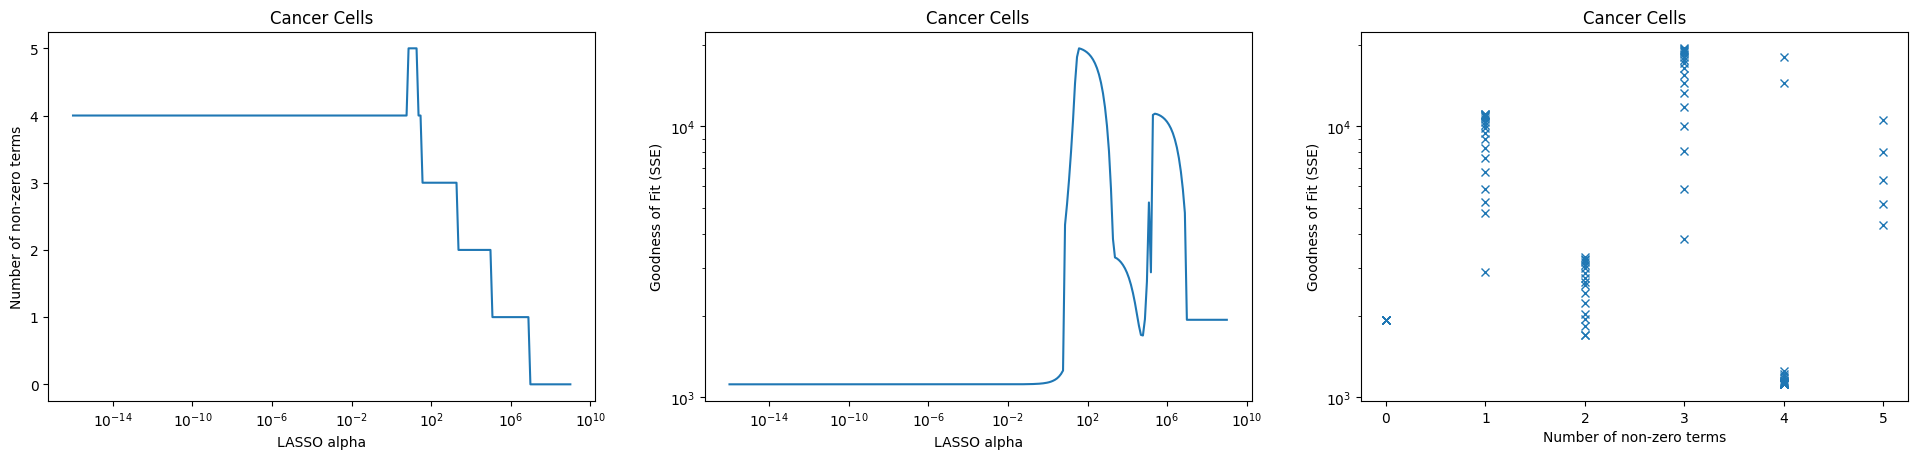

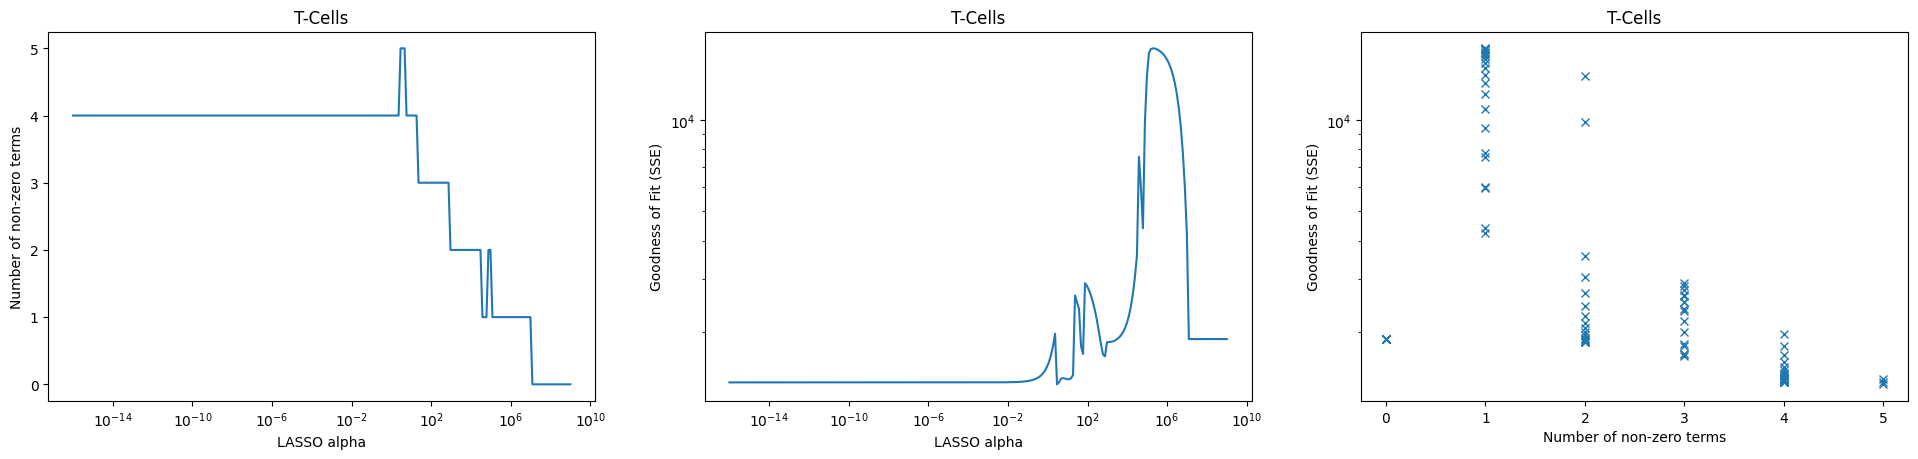

In [7]:
"""
In this section, use np.logspace to define a range to sweep the sparsity parameter alpha.
Choose a range which spans many orders of magnitude, and choose enough samples to
understand the Pareto Front landscape.

Using the below Pareto Front:
  - Select the numer of terms for Cancer cells and T-cells individually
  - Using the number of terms, look-up the corresponding model

"""

cancer_derivative = EstimateDerivative(t_measured,N_cancer)[:-1]
tcell_derivative = EstimateDerivative(t_measured,N_tcells)[:-1]

n_samples = 250
lib_length = 10

alphas = np.logspace(-16,9,n_samples)

nnz_cancer = np.zeros(n_samples)
nnz_tcell = np.zeros(n_samples)
SSE_cancer = np.zeros(n_samples)
SSE_tcell = np.zeros(n_samples)

cancer_models = np.zeros((n_samples,lib_length+1))
tcell_models = np.zeros((n_samples,lib_length+1))


for i, alpha in enumerate(alphas):
    coeffs_tcell, est_tcell, tcell_term_labels = SINDyRegression(t_measured,
                                          N_tcells,
                                          library_length = lib_length, 
                                          lasso_alpha = alpha, 
                                          additional_terms = {'N_cancer':N_cancer})

    coeffs_cancer, est_cancer, cancer_term_labels = SINDyRegression(t_measured,
                                          N_cancer,
                                          library_length = lib_length, 
                                          lasso_alpha = alpha,  
                                          additional_terms = {'N_tcells':N_tcells})

    cancer_models[i,:] = coeffs_cancer
    tcell_models[i, :] = coeffs_tcell

    nnz_cancer[i] = np.count_nonzero(coeffs_cancer)
    nnz_tcell[i] = np.count_nonzero(coeffs_tcell)

    SSE_cancer[i] = np.sum( (cancer_derivative - est_cancer)**2 )
    SSE_tcell[i] = np.sum( (tcell_derivative - est_tcell)**2 )

ParetoPlot(nnz_cancer, SSE_cancer, alphas, 'Cancer Cells')
ParetoPlot(nnz_tcell, SSE_tcell, alphas, 'T-Cells')

In [35]:
'''
Here, you must select the number of terms in the model from your Pareto Front Analsys
simply input your selected number of parameters in the location specified.
'''

CANCER_MODEL = SelectCandidateModel(0, #<-- Number of Terms in Cancer Model
                                    cancer_models, 
                                    nnz_cancer, 
                                    SSE_cancer, 
                                    cancer_term_labels)

TCELL_MODEL = SelectCandidateModel(0, #<-- Number of Terms in T-Cell Model
                                    tcell_models, 
                                    nnz_tcell, 
                                    SSE_tcell, 
                                    tcell_term_labels)

print( 'Cancer ODE: \n\t', CANCER_MODEL )
print( 'T-cell ODE: \n\t', TCELL_MODEL )

Cancer ODE: 
	 dN/dt = 
T-cell ODE: 
	 dN/dt = 


# **Using MarkDown, write your report summary here:**

Question 1:

Question 2: